In [1]:
import os
import polars as pl

import torch
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
from torchinfo import summary
import gc
from torchmetrics.classification import BinaryF1Score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pl.read_parquet(
    r"/home/pampa89d/Repo/mentor/rubert_bynary_clas/data/processed_combined.parquet"
)
df.head()

message,label
str,i64
"""Привет чтото подобное делал ес…",0
"""Я уже сам отключил, через стар…",0
"""Страны ес согласовали санкции …",0
"""Кипячу, не кипячусь я добрая п…",0
"""Avalonia for visual studio 201…",0


In [4]:
small_df = df.sample(n=150_000, shuffle=False)

In [5]:
small_df.group_by("label").len()

label,len
i64,u32
0,138380
1,11620


In [6]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2", num_labels=2
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

Заморозка слоев

In [7]:
# Принудительная очистка
gc.collect()
torch.cuda.empty_cache()

In [8]:
# Пример для передачи двух входов: input_ids
# если нужен attention_mask добавить как список
# input_size = (batch_size, sequence_length)
summary(model, input_size=(16, 512), dtypes=[torch.long])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                       Output Shape              Param #
BertForSequenceClassification                                [16, 2]                   --
├─BertModel: 1-1                                             [16, 312]                 --
│    └─BertEmbeddings: 2-1                                   [16, 512, 312]            --
│    │    └─Embedding: 3-1                                   [16, 512, 312]            26,154,336
│    │    └─Embedding: 3-2                                   [16, 512, 312]            624
│    │    └─Embedding: 3-3                                   [1, 512, 312]             638,976
│    │    └─LayerNorm: 3-4                                   [16, 512, 312]            624
│    │    └─Dropout: 3-5                                     [16, 512, 312]            --
│    └─BertEncoder: 2-2                                      [16, 512, 312]            --
│    │    └─ModuleList: 3-6                                  --                 

In [9]:
class CustomImageDataset(Dataset):
    def __init__(
        self, texts: List, labels: List, tokenizer: AutoTokenizer, max_len: int = 512
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Получаем текст по индексу
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Токенизация для BERT
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(dim=0),
            "attention_mask": encoding["attention_mask"].squeeze(dim=0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [10]:
train_df = small_df[:120_000]
val_df = small_df[120_000:]

training_dataset = CustomImageDataset(train_df["message"], train_df["label"], tokenizer)
val_dataset = CustomImageDataset(val_df["message"], val_df["label"], tokenizer)

In [11]:
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
next(iter(train_dataloader))

{'input_ids': tensor([[    2,   299, 29852,  ...,     0,     0,     0],
         [    2,  8746,  1150,  ...,     0,     0,     0],
         [    2, 11847, 18646,  ...,     0,     0,     0],
         ...,
         [    2,  6226,  6003,  ...,     0,     0,     0],
         [    2,   280, 12133,  ...,     0,     0,     0],
         [    2,  1041, 20558,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0])}

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)
f1_metric = BinaryF1Score().to(device)


def train(model, train_loader, val_loader, optimizer, metric, epochs):
    """
    Функция для обучения и валидации нейросети
    """
    train_losses = []
    valid_losses = []

    f1_scores_train = []
    f1_scores_valid = []

    for epoch in range(epochs):

        model.train()
        train_loss = 0.0
        train_f1 = 0.0

        for batch in tqdm(train_loader):

            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            predict = torch.argmax(outputs.logits, dim=1)

            f1_score = metric(predict, labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_f1 += f1_score.item()
            train_loss += loss.item()

        avg_train_f1 = round((train_f1 / len(train_loader)), 4)
        avg_train_loss = round((train_loss / len(train_loader)), 4)

        f1_scores_train.append(avg_train_f1)
        train_losses.append(avg_train_loss)

        print(
            f"Epoch {epoch+1}. Average train loss {avg_train_loss}. Average train F1_score {avg_train_f1}"
        )

        model.eval()
        val_loss = 0.0
        valid_f1 = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader):

                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids, attention_mask=attention_mask, labels=labels
                )
                predict = torch.argmax(outputs.logits, dim=1)

                f1_score = metric(predict, labels)

                loss = outputs.loss

                valid_f1 += f1_score.item()
                val_loss += loss.item()

        avg_val_f1 = round((valid_f1 / len(val_loader)), 4)
        avg_val_loss = round((val_loss / len(val_loader)), 4)

        f1_scores_valid.append(avg_val_f1)
        valid_losses.append(avg_val_loss)

        print(
            f"Epoch {epoch+1}. Average valid loss {avg_val_loss}. . Average train F1_score {avg_val_f1}."
        )

        # backup
        model.save_pretrained("../models")
        tokenizer.save_pretrained("../models")

    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "f1_scores_train": f1_scores_train,
        "f1_scores_valid": f1_scores_valid,
    }

In [14]:
results = train(model, train_dataloader, val_dataloader, optimizer, f1_metric, epochs=3)

100%|██████████| 3750/3750 [22:53<00:00,  2.73it/s]


Epoch 1. Average train loss 0.0391. Average train F1_score 0.8304


100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


Epoch 1. Average valid loss 0.0186. . Average train F1_score 0.8762.


100%|██████████| 3750/3750 [24:54<00:00,  2.51it/s]


Epoch 2. Average train loss 0.0132. Average train F1_score 0.8879


100%|██████████| 938/938 [02:31<00:00,  6.20it/s]


Epoch 2. Average valid loss 0.0174. . Average train F1_score 0.8797.


100%|██████████| 3750/3750 [25:56<00:00,  2.41it/s]


Epoch 3. Average train loss 0.0073. Average train F1_score 0.9147


100%|██████████| 938/938 [02:39<00:00,  5.87it/s]


Epoch 3. Average valid loss 0.0177. . Average train F1_score 0.8978.


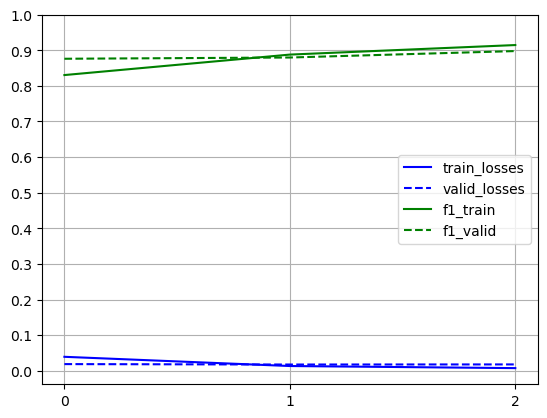

In [15]:
plt.plot(results["train_losses"], color="blue", label="train_losses")
plt.plot(results["valid_losses"], color="blue", linestyle="--", label="valid_losses")
plt.plot(results["f1_scores_train"], color="green", label="f1_train")
plt.plot(results["f1_scores_valid"], color="green", linestyle="--", label="f1_valid")
plt.legend()
plt.xticks([i for i in range(len(results["train_losses"]))])
plt.yticks([(i + 1) * 0.1 for i in range(-1, 10)])
plt.grid()
plt.show()

Загрузка сохранненой модели HF

In [2]:
model = BertForSequenceClassification.from_pretrained("./models")
tokenizer = AutoTokenizer.from_pretrained("./models")

In [31]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [33]:
inputs = tokenizer(
    df.filter(pl.col("label") == 1)[-5:]["message"].to_list(),
    add_special_tokens=True,
    padding=True,
    truncation=True,
    return_tensors="pt",
)

In [37]:
outputs = model(**inputs.to(device))

In [43]:
torch.argmax(outputs.logits, dim=1).cpu().numpy().tolist()

[1, 1, 1, 1, 1]

In [ ]:
df.filter(pl.col("label") == 1)[-5:]["message"].to_list()

['ВАТИТ ЖИТЬ 0Т ЗAР ЛAТЫ ДО ЗAPПЛАТЫ 2 4 чαсσв и твой дохσд от 8000 в день Pа6отαешь ᴋогда удσбнσ. Никαᴋих пρσдаж и встрeч. одσйдет дαжe ᴄтудентαᴍ',
 'Ecть ваpиант пoлyчить 3300 pyблeй за 2 чаca oтпишитe в лc',
 'Нужны cpочho люди нa шaбашку нa 45 чaсов в дeнь плaчy 15тыcяч сразy поcлe смeны',
 'Вaтит жить 0т зaрплаты до заpплаты 2 4 чαсσв и твσй дохσд σт 8000 в дeнь рα6отαeшь кσгдα удσ6но никаᴋи πрσдаж и вᴄтρеч одойдeт дαжe стγдeнтαᴍ',
 'Нужны молодые смекалистые ребята и девушки места ограничены']

In [ ]:
df[100:110]

message,label
str,i64
"""градл ебанутейший, но он же по…",0
"""Не жаловаться, а занять себя н…",0
"""Вы хотите, чтобы верующие жили…",0
"""А если внатуре выложить, забан…",0
"""He oткладывaй на пoтом зaрaбат…",1
"""Ну это да сейчас стоит такая к…",0
"""Там хвалят""",0
"""Опа а я перезаводил ее""",0
"""Компилируется, но ресайкл пуст…",0


In [ ]:
df[100:110]['message'].to_list()

['градл ебанутейший, но он же пойди найди что получше',
 'Не жаловаться, а занять себя нужным делом, или прятным, или общественно полезным',
 'Вы хотите, чтобы верующие жили по нормам ветхого завета, или нового может новейший завет нужен',
 'А если внатуре выложить, забанят тгк мне',
 'He oткладывaй на пoтом зaрaбатывай до 16 000 в дeнь уже сeйчас пиши мне',
 'Ну это да сейчас стоит такая крутая вещь',
 'Там хвалят',
 'Опа а я перезаводил ее',
 'Компилируется, но ресайкл пустой',
 'Им генерал приказал дрочить на скил и орать,что по винке мы всех рвем']

In [63]:
n = 40
low = 400_000+n
high = 400_000+n+15

In [64]:
df['message'][low:high].to_list()

['Tybgpmvy я эти брал в целом понравились борты есть, лежат мертво но есть 2 минуса черные пачкаются очень быстро, мне показалось по ним кроссовки сильнее скользят, чем по обычным резиновым',
 'Лётные испытания ракетного комплекса сармат прошли успешно командующий рвсн',
 'Объёмы в опционах сегодня mrna 819k 56 колл 44 пут aapl 803k 64 колл 36 пут amd 685k 70 колл 30 пут tsla 659k 65 колл 35 пут amc 584k 61 колл 39 пут pfe 518k 73 колл 27 пут wmt 512k 91 колл 9 пут bp 446k 98 колл 2 пут pltr 390k 64 колл 36 пут bac 376k 69 колл 31 пут fubo 345k 75 колл 25 пут nvda 331k 67 колл 33 пут nio 315k 67 колл 33 пут spce 307k 60 колл 40 пут amzn 301k 54 колл 46 пут hyg 288k 9 колл 91 пут coin 282k 76 call 24 пут',
 'Добрый вечер, услуги взлома Делаю взлом_Ы What s App Instagram Вайбер ВКонтактe telegram, Почта. Чистка автотеки Чистка кредит истории Пишите',
 'У россиян начнут изымать загранпаспорта за долги сми такие правила должны появиться до конца года, когда вступит в силу соответствующий з

In [65]:
df['label'][low:high].to_list()

[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]